In [64]:
import datajoint as dj
import os
import numpy as np
import matplotlib.pyplot as plt
from pipeline import pupil, meso
from stimulus import stimulus
from stimulus.utils import get_stimulus_info
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter
from stimline import tune
from sklearn.linear_model import LinearRegression
import pickle
from matplotlib.font_manager import FontProperties

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def normalize_signal(signel, offset=0):
    signel = signel - np.nanmean(signel)
    signel = signel / (np.nanmax(signel) - np.nanmin(signel))
    signel = signel - np.nanmin(signel) + offset
    return signel

def interpolate(to_be_interpolated, to_be_interpolated_times, interpolant_times):
   
    x = to_be_interpolated_times
    f = interp1d(x, to_be_interpolated, bounds_error=False, fill_value='extrapolate') # interpolate function
    xnew = interpolant_times
    trace = f(xnew)
        
    return trace

def calculate_oracle(traces):
    X = []
    for i in range(len(traces)):
        X.append(i)
    correl = []
    for i in range(len(traces)):
        x = X[:]
        x.pop(i)
        mu = np.mean(traces[x], axis = 0)
        correl.append(corr(traces[i], mu))
    return correl

def corr(y1, y2, axis=-1, eps=1e-8, return_p=False, **kwargs):
    """
    Compute the correlation between two matrices along certain dimensions.

    Args:
        y1:      first matrix
        y2:      second matrix
        axis:    dimension along which the correlation is computed.
        eps:     offset to the standard deviation to make sure the correlation is well defined (default 1e-8)
        **kwargs passed to final mean of standardized y1 * y2

    Returns: correlation vector

    """
    y1 = (y1 - y1.mean(axis=axis, keepdims=True)) / (y1.std(axis=axis, keepdims=True, ddof=1) + eps)
    y2 = (y2 - y2.mean(axis=axis, keepdims=True)) / (y2.std(axis=axis, keepdims=True, ddof=1) + eps)
    if not return_p:
        return (y1 * y2).mean(axis=axis, **kwargs)
    else:
        rho = (y1 * y2).mean(axis=axis, **kwargs)
        N = y1.shape[axis] if not isinstance(axis, (tuple, list)) else np.prod([y1.shape[a] for a in axis])
        t = rho / np.sqrt((1 - rho ** 2) / (N - 2))
        prob = distributions.t.sf(np.abs(t), N - 1) * 2
        return rho, prob

def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [229]:
## GET ALL PUPIL TRACES

key = {'animal_id': 14111, 'session': 2, 'scan_idx': 5}
scan_title = "_".join([str(v) for k,v in key.items() if k in ('animal_id', 'session', 'scan_idx')])

pearson_percentile = 0.90
fetch_lim = int(len(tune.MovieOracle.Total & key) * (1-pearson_percentile))
units = (tune.MovieOracle.Total & key).fetch('KEY', order_by='pearson DESC', limit=fetch_lim)

# Get oracle info

stimulus_info = get_stimulus_info(key)
clip_hashes = [a[2]['condition_hash'] for a in stimulus_info if a[3]['type'] == 'stimulus.Clip']
unique_hashes = np.unique(clip_hashes, return_counts=True)
oracle_hashes = unique_hashes[0][np.where(unique_hashes[1] > 9)]

# Get pupil info

pupil_trace = (pupil.FittedPupil.Circle & dict(key,tracking_method=1)).fetch('radius')
pupil_times = (pupil.Eye & dict(key,tracking_method=1)).fetch('eye_time')[0]
depth_num = np.unique((meso.ScanInfo.Field & key).fetch('z')).shape[0]
scan_times = (stimulus.BehaviorSync() & key).fetch1('frame_times')[::depth_num]

# Interpolate and filter pupil trace

pupil_trace_int = np.nan_to_num(interpolate(pupil_trace, pupil_times, scan_times))
fs = len(scan_times)/scan_times[-1]
pupil_trace_int_diff = np.diff(butter_bandpass_filter(pupil_trace_int, 0.1, 1, fs, order=5))

# Get pupil traces for all clips

all_pupil_traces = []
clip_titles = []
for stim_hash in oracle_hashes:
    
    clip_titles.append((stimulus.Clip & f'condition_hash="{stim_hash}"').fetch1('movie_name'))
    stim_start_stop_times = [(a[0],a[1]) for a in stimulus_info if a[2]['condition_hash'] == stim_hash]
    pupil_traces = []
    min_trace_len = 10000000
    
    for n,(start,stop) in enumerate(stim_start_stop_times):
        pupil_traces.append(pupil_trace_int_diff[start:stop])
        if min_trace_len > (stop-start):
            min_trace_len = stop-start
    for n in range(len(pupil_traces)):
        pupil_traces[n] = pupil_traces[n][0:min_trace_len]
    all_pupil_traces.append(pupil_traces)


### Calculate oracles for each unit above the 90th percentile

all_units_oracles = []
all_units_traces = []
for unit in units: 
    
    oracle_trace = (meso.Fluorescence.Trace & (meso.ScanSet.Unit & unit)).fetch1('trace')
    oracle_spikes = (meso.Activity.Trace & unit).fetch1('trace')
    signal = oracle_spikes
    
    oracles_per_clip = []
    traces_per_clip = []
    for stim_hash in oracle_hashes:
        stim_start_stop_times = [(a[0],a[1]) for a in stimulus_info if a[2]['condition_hash'] == stim_hash]
        all_traces = []
        min_trace_len = 10000000
        
        for n,(start,stop) in enumerate(stim_start_stop_times):
            all_traces.append(signal[start:stop])
            if min_trace_len > (stop-start):
                min_trace_len = stop-start
        for n in range(len(all_traces)):
            all_traces[n] = all_traces[n][0:min_trace_len]
        traces_per_clip.append(all_traces)
        
        all_traces = np.array(all_traces)
        oracle = calculate_oracle(all_traces)
        oracles_per_clip.append(oracle)
        
    all_units_oracles.append(oracles_per_clip)
    all_units_traces.append(traces_per_clip)

/usr/local/lib/python3.6/dist-packages/datajoint/connection.py:150: UserWarning: Mysql server has gone away. Reconnecting to the server.
  warnings.warn("Mysql server has gone away. Reconnecting to the server.")


unit_id or segmentation_method was unspecified, not using ms_delay
field unspecified, not using field offset


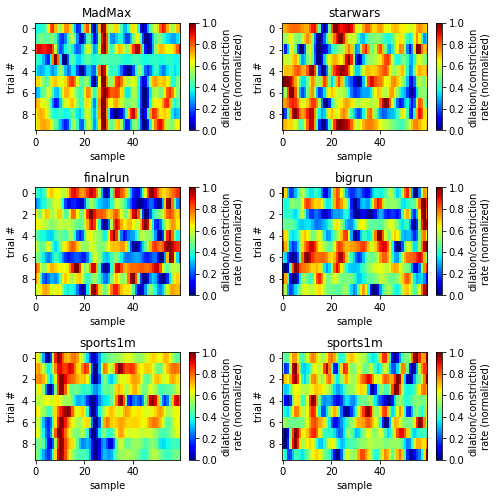

In [230]:
# Plot pupil traces and calculate pupil oracles

jet = cm = plt.get_cmap('jet')

pupil_oracles = []
fig, axs = plt.subplots(3, 2, figsize=(7,7))
count = -1
for n in range(3):
    for m in range(2):
        count += 1
        all_traces = []
        for i in range(10):
            all_traces.append(normalize_signal(all_pupil_traces[count][i]))
        all_traces = np.array(all_traces)

        oracle = calculate_oracle(all_traces)
        pupil_oracles.append(oracle)

        ax = axs[n, m]
        im = axs[n, m].imshow(all_traces, aspect='auto', cmap=jet)
        cbar = fig.colorbar(im, ax=ax)
        cbar.ax.set_ylabel('dilation/constriction\nrate (normalized)', fontsize=10)
        axs[n, m].set(xlabel='sample', ylabel='trial #', title=f'{clip_titles[count]}')

for ax in axs.flat:
    ax.label_outer()
fig.tight_layout(pad=1.0)
output_path = os.path.join('/data/mylaptop/pupil_trials/'+f'{scan_title}'+'.eps')
plt.savefig(output_path, dpi=100)

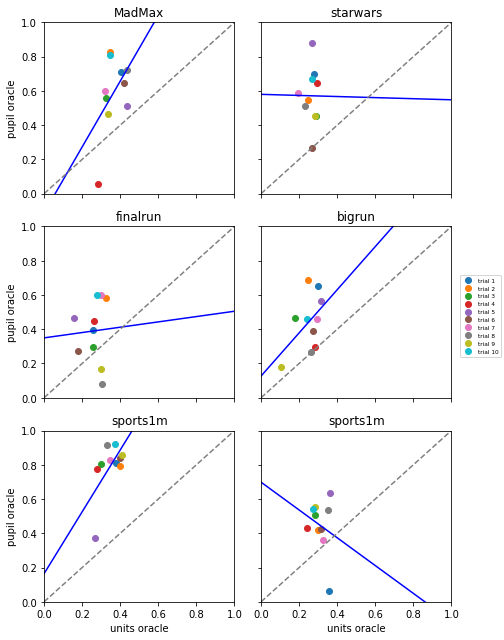

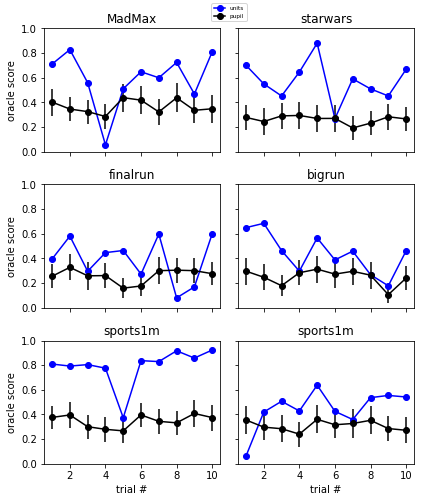

In [231]:
# Reshape oracle scores per trial of each unit

units_oracles_per_trial = []
for i in range(len(oracle_hashes)):
    oracles_per_clip = []
    for j in range(len(all_units_oracles[0][0])):
        oracles_per_trial = []
        for k in range(len(all_units_oracles)):
            oracles_per_trial.append(all_units_oracles[k][i][j])
        oracles_per_clip.append(oracles_per_trial)
    units_oracles_per_trial.append(oracles_per_clip)

# Calculate average oracle for all units for each trial
    
all_avg_units_oracles = []
all_std_units_oracles = []
all_y = []
all_slopes = []
for k in range(len(all_units_oracles[0])):

    # Calculate average trial oracle

    avg_units_oracles = []
    std_units_oracles = []
    for j in range(len(units_oracles_per_trial[0])):
        avg_units_oracles.append(np.mean(units_oracles_per_trial[k][j]))
        std_units_oracles.append(np.std(units_oracles_per_trial[k][j]))
    all_avg_units_oracles.append(avg_units_oracles)
    all_std_units_oracles.append(std_units_oracles)

    # Build a linear model to fit avg_units_oracles and pupil oracles

    unit = all_avg_units_oracles[k]

    unit = np.array(unit)
    unit = unit.reshape(-1,1)
    model = LinearRegression().fit(unit, pupil_oracles[k])
    r_sq = model.score(unit, pupil_oracles[k])
    #print('coefficient of determination:', r_sq)
    #print('intercept:', model.intercept_)
    #print('slope:', model.coef_)
    y_pred = model.predict(unit)
    #print('predicted response:', y_pred, sep='\n')

    x = np.linspace(0, 1, num=len(units_oracles_per_trial[0]), endpoint=True)
    y = model.coef_*x + model.intercept_
    all_y.append(y)
    all_slopes.append(model.coef_)

# Plot avg_unit_oracle against pupil_oracles

color_dict = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']
fig, axs = plt.subplots(3, 2, figsize=(7,9))
line_labels = ["trial 1", "trial 2", "trial 3", "trial 4", "trial 5", "trial 6", "trial 7", "trial 8", "trial 9", "trial 10"]
fontP = FontProperties()
fontP.set_size('xx-small')
count = -1
dots = []
for n in range(3):
    for m in range(2):
        count += 1
        for i in range(len(all_units_oracles[0][count])):
            dots.append(axs[n, m].plot(all_avg_units_oracles[count][i], pupil_oracles[count][i], 'o', markersize=6, color=color_dict[i]))

        axs[n, m].plot(x, all_y[count], c='b')
        add_identity(axs[n, m], color='gray', ls='--')

        axs[n, m].set(xlabel='units oracle', ylabel='pupil oracle', title=f'{clip_titles[count]}', xlim=(0,1), ylim=(0,1))
fig.legend(labels=line_labels, loc="center right", bbox_to_anchor=(1, 0.5), prop=fontP)
for ax in axs.flat:
    ax.label_outer()
fig.tight_layout(rect=[0, 0, 0.94, 1])
# output_path = os.path.join('/data/mylaptop/pupil_oracles_vs_traces_oracles/'+f'{scan_title}'+'.eps')
# plt.savefig(output_path, dpi=100)
    

# Plot average oracle scores accross trials 

fig, axs = plt.subplots(3, 2, figsize=(6,7))
line_labels = ["units", "pupil"]
count = -1
for n in range(3):
    for m in range(2):
        count += 1
        x = np.linspace(1, 10, num=10, endpoint=True)
        avg_units_oracles = np.array(all_avg_units_oracles[count])
        std_units_oracles = np.array(all_std_units_oracles[count])
        e = std_units_oracles/(len(avg_units_oracles)**0.5)
        l1 = axs[n, m].errorbar(x, all_avg_units_oracles[count], e, fmt='-o', c='black')
        l2 = axs[n, m].plot(x, pupil_oracles[count], '-o', c='blue')
        axs[n, m].set(xlabel='trial #', ylabel='oracle score', title=f'{clip_titles[count]}', ylim=(0,1))
fig.legend(labels=line_labels, loc="upper center", bbox_to_anchor=(0.53, 0.995), prop=fontP)
for ax in axs.flat:
    ax.label_outer()
fig.tight_layout()
# output_path = os.path.join('/data/mylaptop/avg_oracle_scores/'+f'{scan_title}'+'.eps')
# plt.savefig(output_path, dpi=100)

